In [1]:
import numpy as np
import pandas as pd
import s3fs
import xarray
import geopandas as gpd

In [2]:
bucket_uri = 's3://geoglows-v2-retrospective/retrospective.zarr'
region_name = 'us-west-2'
s3 = s3fs.S3FileSystem(anon=True, client_kwargs=dict(region_name=region_name))
s3store = s3fs.S3Map(root=bucket_uri, s3=s3, check=False)

In [3]:
ds = xarray.open_zarr(s3store)

In [4]:
reach_id = [160762267]

In [5]:
df = ds['Qout'].sel(rivid=reach_id).to_dataframe()
df = df.reset_index().set_index('time').pivot(columns='rivid', values='Qout')

In [6]:
df = df[(df.index > '1945-12-31')]

In [7]:
df

rivid,160762267
time,
1946-01-01,395.947083
1946-01-02,345.619080
1946-01-03,306.360809
1946-01-04,277.602631
1946-01-05,257.318726
...,...
2024-12-27,495.566010
2024-12-28,450.252991
2024-12-29,410.459991


In [8]:
df.columns

Index([160762267], dtype='int32', name='rivid')

In [9]:
# Assuming df is your DataFrame and "160144862" is the column name
data = df[160762267].sort_values().reset_index(drop=True)

# Number of values
n = len(data)

# Weibull plotting positions
data_ranked = data.reset_index()
data_ranked.columns = ['rank', 'value']
data_ranked['P'] = (data_ranked['rank'] + 1) / (n + 1)

# Calculate the 95th percentile using interpolation
percentile_95th = data_ranked[data_ranked['P'] >= 0.05].iloc[0]['value']

percentile_95th

211.58123779296875

In [10]:
df['7_day_avg'] = df[reach_id].rolling(window='7D').mean()

In [11]:
df

rivid,160762267,7_day_avg
time,,
1941-01-01,2185.335693,2185.335693
1941-01-02,2079.081787,2132.208740
1941-01-03,1974.701050,2079.706177
1941-01-04,1874.620850,2028.434845
1941-01-05,1782.555176,1979.258911
...,...,...
2024-07-26,1198.830200,992.413330
2024-07-27,1210.455933,1054.763288
2024-07-28,1217.554077,1110.418815


In [12]:
below_percentile_95th = df['7_day_avg'] < percentile_95th

# Filter rows where the condition is True
df_below_percentile_95th = df[below_percentile_95th]

# Display the result
df_below_percentile_95th

rivid,160762267,7_day_avg
time,,
1946-01-14,192.165039,207.912467
1946-01-15,188.328903,202.624217
1946-01-16,185.623871,197.871011
1946-01-17,184.118103,193.749943
1946-01-18,183.946472,190.413130
...,...,...
2024-04-13,166.775360,127.421532
2024-04-14,195.393265,139.407357
2024-04-15,229.461670,156.864382


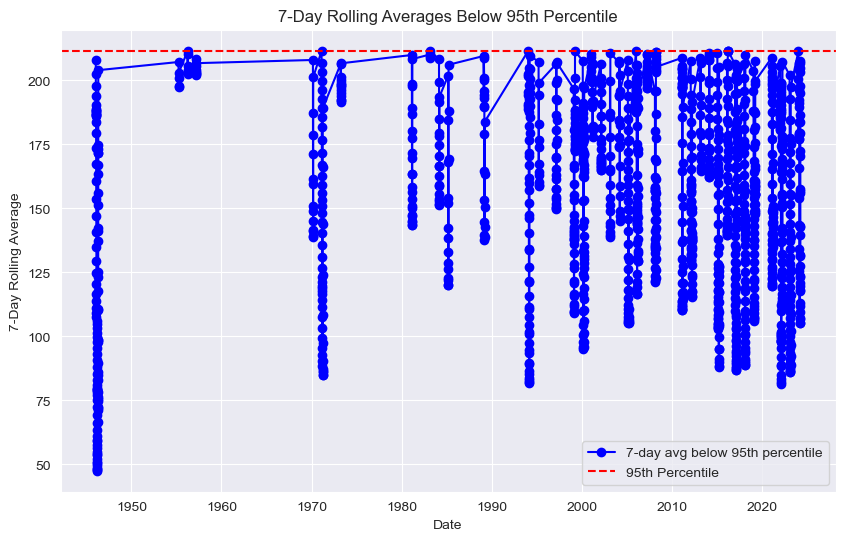

In [13]:
import matplotlib.pyplot as plt

# Assuming df_below_percentile_95th is already defined as shown in the previous example

# Plotting the 7-day averages below the 95th percentile
plt.figure(figsize=(10, 6))
plt.plot(df_below_percentile_95th.index, df_below_percentile_95th['7_day_avg'], marker='o', linestyle='-', color='b', label='7-day avg below 95th percentile')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('7-Day Rolling Average')
plt.title('7-Day Rolling Averages Below 95th Percentile')
plt.axhline(y=percentile_95th, color='r', linestyle='--', label='95th Percentile')

# Adding legend
plt.legend()

# Show the plot
plt.show()


/var/folders/7b/d70_71nx15l_shf2zfg77d3h0000gp/T/ipykernel_79601/1820123619.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_below_percentile_95th['Month'] = df_below_percentile_95th.index.month


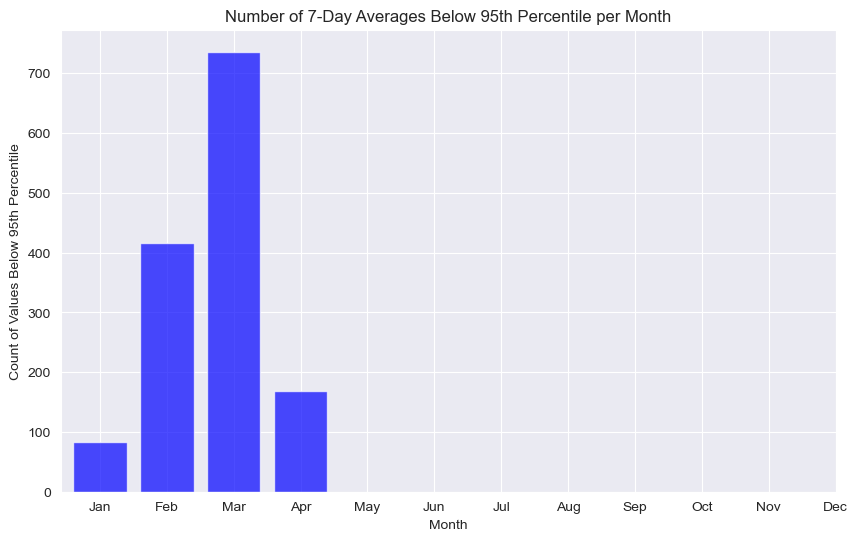

In [14]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure the DataFrame 'df_below_percentile_95th' is defined from the previous step

# Extract the month from the datetime index
df_below_percentile_95th['Month'] = df_below_percentile_95th.index.month

# Group the values by month and count the occurrences
monthly_counts = df_below_percentile_95th.groupby('Month').size()

# Create the histogram plot
plt.figure(figsize=(10, 6))
plt.bar(monthly_counts.index, monthly_counts.values, color='b', alpha=0.7)

# Adding labels and title
plt.xlabel('Month')
plt.ylabel('Count of Values Below 95th Percentile')
plt.title('Number of 7-Day Averages Below 95th Percentile per Month')

# Set x-ticks to correspond to month names
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

# Show the plot
plt.show()

In [15]:
monthly_counts

Month
1     84
2    416
3    736
4    169
dtype: int64

/var/folders/7b/d70_71nx15l_shf2zfg77d3h0000gp/T/ipykernel_79601/4030016240.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_below_percentile_95th['Year'] = df_below_percentile_95th.index.year


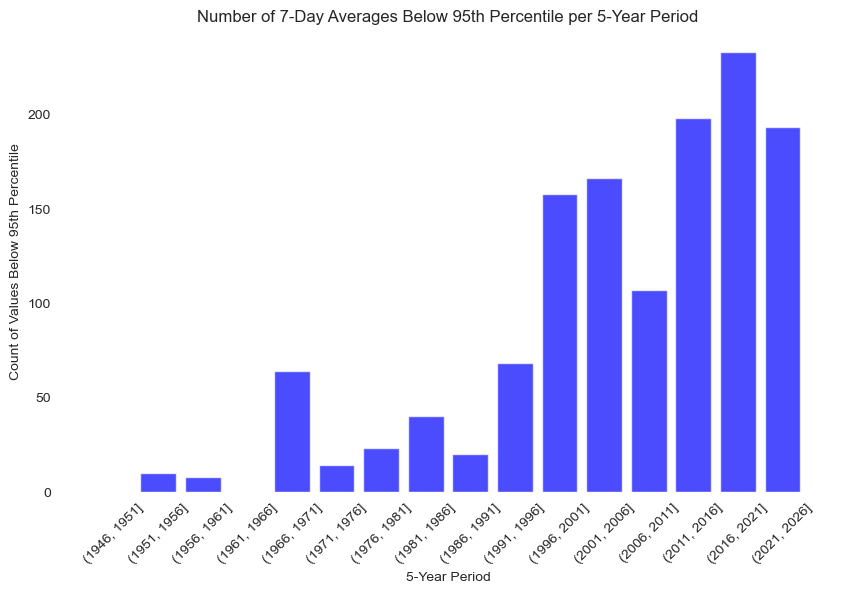

/var/folders/7b/d70_71nx15l_shf2zfg77d3h0000gp/T/ipykernel_79601/4030016240.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_below_percentile_95th['Year'] = df_below_percentile_95th.index.year


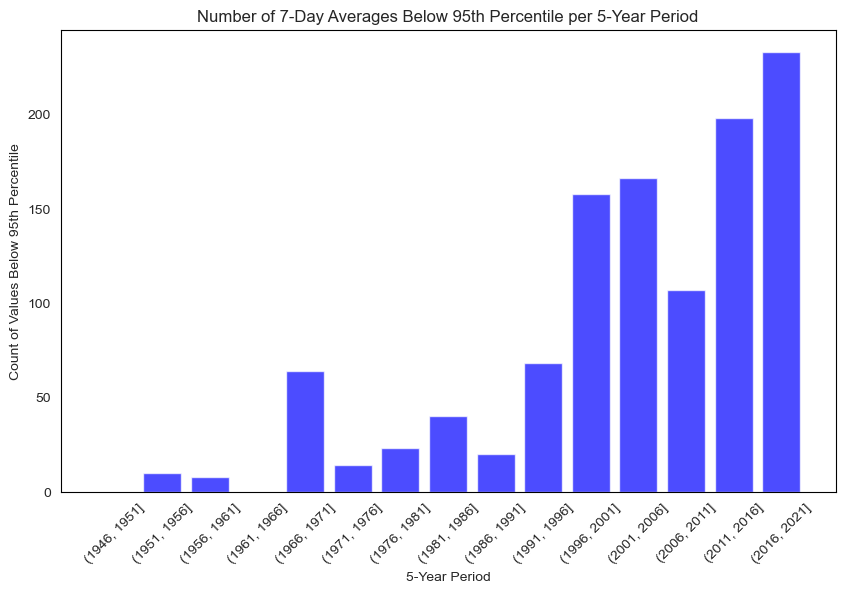

In [18]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming df_below_percentile_95th is already defined

# Extract the year from the datetime index
df_below_percentile_95th['Year'] = df_below_percentile_95th.index.year

# Define 5-year bins (you can adjust this range based on your data)
year_bins = pd.cut(df_below_percentile_95th['Year'],
                   bins=range(df_below_percentile_95th['Year'].min(), df_below_percentile_95th['Year'].max() + 6, 5))

# Count the occurrences in each 5-year bin
yearly_counts = year_bins.value_counts().sort_index()

# Create the histogram plot
plt.figure(figsize=(10, 6), facecolor="white")
plt.bar(yearly_counts.index.astype(str), yearly_counts.values, color='b', alpha=0.7)

# Adding labels and title
plt.xlabel('5-Year Period')
plt.ylabel('Count of Values Below 95th Percentile')
plt.title('Number of 7-Day Averages Below 95th Percentile per 5-Year Period')

# Rotate x-ticks for better readability
plt.xticks(rotation=45)
plt.gca().set_facecolor('white')
plt.savefig("/Users/rachel1/Downloads/high_resolution_for_thesis/count_below_95th_percentileNEW.png", dpi=600,
            bbox_inches='tight', facecolor='white')
# Show the plot
plt.show()

# Extract the year from the datetime index
df_below_percentile_95th['Year'] = df_below_percentile_95th.index.year

# Define 5-year bins (you can adjust this range based on your data)
year_bins = pd.cut(df_below_percentile_95th['Year'],
                   bins=range(df_below_percentile_95th['Year'].min(),
                              df_below_percentile_95th['Year'].max() + 6, 5))

# Count the occurrences in each 5-year bin
yearly_counts = year_bins.value_counts().sort_index()

# Drop the last bin if it's incomplete
if yearly_counts.index[-1].right > df_below_percentile_95th['Year'].max():
    yearly_counts = yearly_counts[:-1]

# Create the histogram plot
plt.figure(figsize=(10, 6), facecolor="white")
plt.bar(yearly_counts.index.astype(str), yearly_counts.values, color='b', alpha=0.7)

# Adding labels and title
plt.xlabel('5-Year Period')
plt.ylabel('Count of Values Below 95th Percentile')
plt.title('Number of 7-Day Averages Below 95th Percentile per 5-Year Period')

# Set axis colors to black
plt.gca().spines['top'].set_color('black')
plt.gca().spines['right'].set_color('black')
plt.gca().spines['left'].set_color('black')
plt.gca().spines['bottom'].set_color('black')

# Rotate x-ticks for better readability
plt.xticks(rotation=45)
plt.gca().set_facecolor('white')
plt.savefig("/Users/rachel1/Downloads/high_resolution_for_thesis/count_below_95th_percentile5.png", dpi=600,
            bbox_inches='tight', facecolor='white')
# Show the plot
plt.show()


In [17]:
streams_122 =gpd.read_file(f'/Volumes/EB406_T7_2/source_streams/streams_122.gpkg')

In [18]:
streams_122

,LINKNO,DSLINKNO,strmOrder,USContArea,DSContArea,TDXHydroRegion,VPUCode,TopologicalOrder,LengthGeodesicMeters,TerminalLink,musk_k,musk_x,geometry
0,160002338,160004674,2,1.095103e+07,4.789257e+07,1020034170,122,166769,7466.008877,160011683,29864,0.25,"MULTILINESTRING ((3461071.395 3707215.619, 346..."
1,160021028,160024532,2,1.182059e+07,3.562392e+07,1020034170,122,166770,3562.711534,160011683,14251,0.25,"MULTILINESTRING ((3477150.877 3701758.205, 347..."
2,160023364,160024532,2,1.035763e+07,2.830945e+07,1020034170,122,166771,4383.655706,160011683,17535,0.25,"MULTILINESTRING ((3475765.568 3699131.970, 347..."
3,160022196,160031541,2,1.222553e+07,2.349319e+07,1020034170,122,166772,2740.467247,160011683,10962,0.25,"MULTILINESTRING ((3485809.059 3700365.214, 348..."
4,160026868,160044390,2,1.112470e+07,3.605825e+07,1020034170,122,166773,15194.297655,160053734,60777,0.25,"MULTILINESTRING ((3489915.512 3698421.097, 348..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
162436,160106301,160068923,9,2.885522e+12,2.885523e+12,1020034170,122,333103,7827.391293,160064246,6725,0.25,"LINESTRING (3397347.171 3672003.061, 3397347.1..."
162437,160068923,160101623,9,2.885547e+12,2.885555e+12,1020034170,122,333104,22616.721908,160064246,19430,0.25,"LINESTRING (3387464.474 3686704.915, 3387452.1..."
162438,160101623,160102791,9,2.886101e+12,2.886101e+12,1020034170,122,333105,1482.627495,160064246,1274,0.25,"LINESTRING (3387291.310 3688357.260, 3387303.6..."
162439,160102791,160064246,9,2.886214e+12,2.886217e+12,1020034170,122,333106,3844.007348,160064246,3302,0.25,"LINESTRING (3383964.094 3690241.787, 3383976.4..."


In [19]:
print(streams_122)

           LINKNO   DSLINKNO  strmOrder    USContArea    DSContArea  \
0       160002338  160004674          2  1.095103e+07  4.789257e+07   
1       160021028  160024532          2  1.182059e+07  3.562392e+07   
2       160023364  160024532          2  1.035763e+07  2.830945e+07   
3       160022196  160031541          2  1.222553e+07  2.349319e+07   
4       160026868  160044390          2  1.112470e+07  3.605825e+07   
...           ...        ...        ...           ...           ...   
162436  160106301  160068923          9  2.885522e+12  2.885523e+12   
162437  160068923  160101623          9  2.885547e+12  2.885555e+12   
162438  160101623  160102791          9  2.886101e+12  2.886101e+12   
162439  160102791  160064246          9  2.886214e+12  2.886217e+12   
162440  160064246         -1          9  2.886297e+12  2.886299e+12   

       TDXHydroRegion  VPUCode  TopologicalOrder  LengthGeodesicMeters  \
0          1020034170      122            166769           7466.008877   

In [52]:
i=1
percentile_95th_dict = {}
for linkno in streams_122["LINKNO"]:
    df = ds['Qout'].sel(rivid=linkno).to_dataframe()
    df = df.reset_index().set_index('time').pivot(columns='rivid', values='Qout')
    df = df[(df.index > '1940-12-31')]
    data = df[linkno].sort_values().reset_index(drop=True)

    # Number of values
    n = len(data)

    # Weibull plotting positions
    data_ranked = data.reset_index()
    data_ranked.columns = ['rank', 'value']
    data_ranked['P'] = (data_ranked['rank'] + 1) / (n + 1)

    # Calculate the 95th percentile using interpolation
    percentile_95th = data_ranked[data_ranked['P'] >= 0.05].iloc[0]['value']
    percentile_95th_dict[linkno] = percentile_95th


    print(i)
    i=i+1

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [53]:
i

In [54]:
linkno

In [55]:
print(linkno)

In [56]:
print(percentile_95th_dict)

In [57]:
print("hello")

In [58]:
# Assuming 'percentile_95th_dict' is already defined

# Convert the dictionary to a DataFrame
percentile_95th_df = pd.DataFrame.from_dict(percentile_95th_dict, orient='index', columns=['percentile_95th'])

# Reset the index to make 'LINKNO' a column
percentile_95th_df.reset_index(inplace=True)

# Rename the 'index' column to 'LINKNO'
percentile_95th_df.rename(columns={'index': 'LINKNO'}, inplace=True)

# Display the resulting DataFrame
print(percentile_95th_df)

In [59]:
percentile_95th_df.to_csv("/Users/rachel1/Downloads/95th.csv")

In [20]:
streams_122_filtered = streams_122[~streams_122['LINKNO'].isin(percentile_95th_df['LINKNO'])]

# Display the resulting DataFrame
print(streams_122_filtered)

           LINKNO   DSLINKNO  strmOrder    USContArea    DSContArea  \
15212   160034458  160354491          2  1.293914e+07  2.269629e+07   
15213   160039130  160398874          2  1.033873e+07  2.169500e+07   
15214   160043802  160355659          2  1.289321e+07  2.740666e+07   
15215   160412890  160514506          2  1.090406e+07  1.424865e+07   
15216   160048474  160525018          2  1.102738e+07  2.053495e+07   
...           ...        ...        ...           ...           ...   
162436  160106301  160068923          9  2.885522e+12  2.885523e+12   
162437  160068923  160101623          9  2.885547e+12  2.885555e+12   
162438  160101623  160102791          9  2.886101e+12  2.886101e+12   
162439  160102791  160064246          9  2.886214e+12  2.886217e+12   
162440  160064246         -1          9  2.886297e+12  2.886299e+12   

       TDXHydroRegion  VPUCode  TopologicalOrder  LengthGeodesicMeters  \
15212      1020034170      122            182402           3086.871226   